
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>




#### Midé Mabadeje$^{1}$ [GitHub](https://github.com/Mide478) | [GoogleScholar](https://scholar.google.com/citations?user=9nksjzQAAAAJ&hl=en&oi=ao)  | [LinkedIn](https://www.linkedin.com/in/ademidemabadeje) & Michael Pyrcz$^{1,2}$ (Professor) [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1), University of Texas at Austin

 1. Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
 2. Department of Earth & Planetary Sciences, Jackson School of Geosciences


# Spatial Data Analytics to Support Declustering Approaches


## Executive Summary
All sparsely sampled, spatial datasets are biased. Cell-based declustering (CBD) is the most applied approach for debiasing such datasets. Current practice for choice of cell size in CBD is irrational and subjective because it is overly conservative. We propose a novel method, Spatial Statistics-based Assignment of Declustering Cell Size (SSADC), which objectively selects the cell size using spatial point statistics; Nearest Neighbors and Ripley’s K to determine the scales of data clustering between data points.

SSADC provides an alternative input for optimal cell size selection using spatial statistics in CBD with the aim to automate and improve objectivity for the mitigation of sampling bias. Cell size determined via SSADC was found to be a better estimate of the true mean regardless of the degree of bias in the data. Therefore, the proposed method is recommended for automated optimal spatial debiasing with sparsely sampled settings.


## Objective 
Develop a new automated quantitative method that objectively, and robustly identifies the optimal cell size for cell based declustering in sparsely sampled spatial datasets. For full paper see [article](https://doi.org/10.1016/B978-0-323-90185-7.00009-1).


This notebook is broken into primary steps of:
        
* Perform cell-based declustering using current approach to determine optimal cell size.

* Determine the optimal cell sizes using proposed SSADC approach i.e., nearest neighbors and Ripley's K, and estimate the declustered statistics.
    
* Results Analysis.


## Getting Started

Here's the steps to get setup in Python with the "package name" :

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install "package name". 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the "package name" functionality.
5. Ensure R is installed on the PC used

After installing these packages let's import them as libraries for our workflow.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import json

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mtick
import seaborn as sns
import geostatspy.geostats as geostats    
import geostatspy.GSLIB as GSLIB          
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

plt.rc('axes', grid=False)
sns.set_style("white")

Next, we need to set the working directory  

### Set Working Directory 

In [2]:
%pwd # This gives the current working directory. Useful to run R commands.

'/Users/ademidemabadeje/Documents/UT/Research/PyCharm/SSADC/Warm Up To be Transferred/Current Scripts'

### Declare Functions 


Functions used in the entirety of this notebook are defined in this section.

In [3]:
# Modified declustering fn from geostatspy package
def declus(df, xcol, ycol, vcol, iminmax, noff, ncell, cmin, cmax):
    
    """GSLIB's DECLUS program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    Note this was simplified to 2D only.
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param iminmax: 1 / True: for use cell size with max decluster mean
                    0 / False: for declustered mean minimizing cell size
    :param noff: number of offsets
    :param ncell: number of cell sizes
    :param cmin: min cell size
    :param cmax: max cell size
    :return: TODO
    """
    # Load data and set up arrays
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    v = df[vcol].values
    wt = np.zeros(nd)
    wtopt = np.ones(nd)
    index = np.zeros(nd, np.int32)
    xcs_mat = np.zeros(ncell + 2)  # we use 1,...,n for this array
    vrcr_mat = np.zeros(ncell + 2)  # we use 1,...,n for this array
    anisy = 1.0  # hard code the cells to 2D isotropic
    roff = float(noff)

    # Calculate extents
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    # Calculate summary statistics
    vmean = np.mean(v)
    vstdev = np.std(v)
    vmin = np.min(v)
    vmax = np.max(v)
    xcs_mat[0] = 0.0
    vrcr_mat[0] = vmean
    vrop = vmean  # include the naive case

    print(f"There are {nd} data with:")
    print(f"   mean of      {vmean} ")
    print(f"   min and max  {vmin} and {vmax}")
    print(f"   standard dev {vstdev} ")

    # Define a "lower" origin to use for the cell sizes
    xo1 = xmin - 0.01
    yo1 = ymin - 0.01

    # Define the increment for the cell size
    xinc = (cmax - cmin) / ncell
    yinc = xinc

    # Loop over "ncell+1" cell sizes in the grid network
    ncellx = int((xmax - (xo1 - cmin)) / cmin) + 1
    ncelly = int((ymax - (yo1 - cmin * anisy)) / cmin) + 1
    ncellt = ncellx * ncelly
    cellwt = np.zeros(ncellt)
    xcs = cmin - xinc
    ycs = (cmin * anisy) - yinc

    # Main loop over cell sizes
    # 0 index is the 0.0 cell, note n + 1 in Fortran
    for lp in range(1, ncell + 2):
        xcs = xcs + xinc
        ycs = ycs + yinc

        # Initialize the weights to zero
        wt.fill(0.0)

        # Determine the maximum number of grid cells in the network
        ncellx = int((xmax - (xo1 - xcs)) / xcs) + 1
        ncelly = int((ymax - (yo1 - ycs)) / ycs) + 1
        ncellt = float(ncellx * ncelly)  # TODO: not used

        # Loop over all the origin offsets selected
        xfac = min((xcs / roff), (0.5 * (xmax - xmin)))
        yfac = min((ycs / roff), (0.5 * (ymax - ymin)))
        for kp in range(1, noff + 1):
            xo = xo1 - (float(kp) - 1.0) * xfac
            yo = yo1 - (float(kp) - 1.0) * yfac

            # Initialize the cumulative weight indicators
            cellwt.fill(0.0)

            # Determine which cell each datum is in
            for i in range(0, nd):
                icellx = int((x[i] - xo) / xcs) + 1
                icelly = int((y[i] - yo) / ycs) + 1
                icell = icellx + (icelly - 1) * ncellx
                index[i] = icell   #  !!!
                # cellwt[icell] = cellwt[icell] + 1.0     
                if icell < len(cellwt):
                    cellwt[icell] = cellwt[icell] + 1.0     

            # The weight assigned to each datum is inversely proportional to the
            # number of data in the cell. We first need to get the sum of
            # weights so that we can normalize the weights to sum to one
            sumw = 0.0
            for i in range(0, nd):
                ipoint = index[i]
                # sumw = sumw + (1.0 / cellwt[ipoint])     
                if ipoint < len(cellwt):
                    sumw = sumw + (1.0 / cellwt[ipoint])
            sumw = 1.0 / sumw

            # Accumulate the array of weights (that now sum to one)
            for i in range(0, nd):
                ipoint = index[i]
                # wt[i] = wt[i] + (1.0 / cellwt[ipoint]) * sumw       
                if ipoint < len(cellwt):
                    wt[i] = wt[i] + (1.0 / cellwt[ipoint]) * sumw

        # End loop over all offsets

        # Compute the weighted average for this cell size
        sumw = 0.0
        sumwg = 0.0
        for i in range(0, nd):
            sumw = sumw + wt[i]
            sumwg = sumwg + wt[i] * v[i]
        vrcr = sumwg / sumw
        vrcr_mat[lp] = vrcr
        xcs_mat[lp] = xcs

        # See if this weighting is optimal
        if iminmax and vrcr < vrop or not iminmax and vrcr > vrop or ncell == 1:
            best = xcs  # TODO: not used
            vrop = vrcr
            wtopt = wt.copy()  # deep copy

    # End main loop over all cell sizes

    # Get the optimal weights
    sumw = 0.0
    for i in range(0, nd):
        sumw = sumw + wtopt[i]
    wtmin = np.min(wtopt)  # TODO: not used
    wtmax = np.max(wtopt)  # TODO: not used
    facto = float(nd) / sumw
    wtopt = wtopt * facto
    return wtopt, xcs_mat, vrcr_mat


def add_grid():
    plt.gca().grid(True, which='major', linewidth=1.0);
    plt.gca().grid(True, which='minor', linewidth=0.2)  # add y grids
    plt.gca().tick_params(which='major', length=7);
    plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator());
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())  # turn on minor ticks

# Load Data

In [4]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # example dataset with preferential sampling
biased_samples = df.loc[:,["X", "Y", "Porosity"]].copy()
biased_samples.head()

,X,Y,Porosity
0,100,900,0.115359
1,100,800,0.136425
2,100,600,0.135810
3,100,500,0.094414
4,100,100,0.113049


Obtain summary statistics for example biased dataset

In [5]:
biased_samples.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,289.0,475.813149,254.277530,0.000000,300.000000,430.000000,670.00000,990.00000
Y,289.0,529.692042,300.895374,9.000000,269.000000,549.000000,819.00000,999.00000
Porosity,289.0,0.134744,0.037745,0.058548,0.106318,0.126167,0.15422,0.22879


Specify the area of interest. i.e., the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display.

In [6]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.26;             # range of porosity values
cmap = plt.cm.inferno                    # color map
name = 'Porosity'                       # feature of interest name

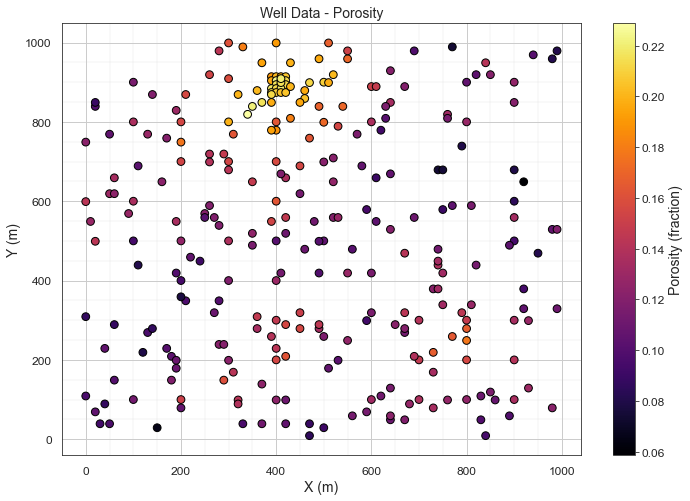

In [7]:
sc = plt.scatter(biased_samples['X'], biased_samples['Y'], c=biased_samples[name], cmap=cmap, s=60, edgecolor='k')
plt.xlabel('X (m)', fontsize=14)
plt.ylabel('Y (m)', fontsize=14)
plt.title('Well Data - Porosity', fontsize=14)
plt.tick_params(axis='both', labelsize=12)

# Add a colorbar with a title
cbar = plt.colorbar(sc)
cbar.set_label('Porosity (fraction)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
add_grid()
plt.show()

Look carefully, and you'll notice the spatial samples are more dense in the high porosity regions and lower in the low porosity regions. There is preferential sampling. We cannot use the naive statistics to represent this region. We have to correct for the clustering of the samples in the high porosity regions.

# Current Approach for Cell-size Selection in Cell-based Declustering (CBD)


Using the current approach for the determination of optimal cell size over a given range of cell sizes as proposed by Journel (1983) and Deutsch (1989), the declustered mean porosity for each realization is estimated.

In [8]:
wts, cell_sizes, dmeans = geostats.declus(biased_samples,'X','Y',name,iminmax = 1, noff= 10, ncell=100,cmin=1,cmax=2000)
biased_samples['Wts'] = wts

naive_mean = np.average(biased_samples[name].values)
CBD_mean = np.average(biased_samples[name].values, weights=biased_samples['Wts'].values)
rel_CBD_error = ((naive_mean-CBD_mean)*100)/naive_mean #
opt_cell = cell_sizes[np.where(np.isin(dmeans, dmeans.min()))].item(0) # Tells the minimizing cell size that gives the CBD_mean

x_and_y_vals = {'X': biased_samples['X'].tolist(), 'Y': biased_samples['Y'].tolist()}

result = {
    'naive': [naive_mean],
    'CBDpor': [CBD_mean],
    'rel_CBD': [rel_CBD_error],
    'cbd_cellsize': [opt_cell]
}

#Let's convert the result dictionary created to dataframe consisting of needed variables.
data = pd.DataFrame.from_dict(result)
# data.to_csv( "CBD_Example_result.csv")

# Serialize X,Y coordinates into file:
json.dump(x_and_y_vals, open("XYcoords.json", 'w'))

# Uncomment and run below if loading data from file after being run
# saved_result = pd.read_csv("CBD_Example_result.csv", index_col=0) # load last stored csv
# data = saved_result.reset_index(drop=True)
# XYcoords = json.load( open( "XYcoords.json" ) )# Read stored X,Y coordinates from file
# data.head()

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385208 


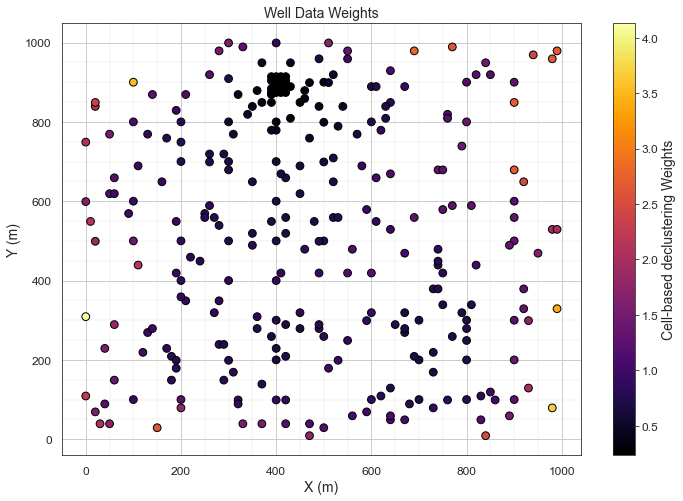

In [9]:
sc = plt.scatter(biased_samples['X'], biased_samples['Y'], c=biased_samples['Wts'], cmap=cmap, s=60, edgecolor='k')
plt.xlabel('X (m)', fontsize=14)
plt.ylabel('Y (m)', fontsize=14)
plt.title('Well Data Weights', fontsize=14)
plt.tick_params(axis='both', labelsize=12)

# Add a colorbar with a title
cbar = plt.colorbar(sc)
cbar.set_label('Cell-based declustering Weights', fontsize=14)
cbar.ax.tick_params(labelsize=12)

add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

Does it look correct? See the weight varies with local sampling density?

Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

Porosity naive mean is 0.135
Porosity declustered mean for CBD is 0.121
Using the naive porosity yields an error of 10.2%


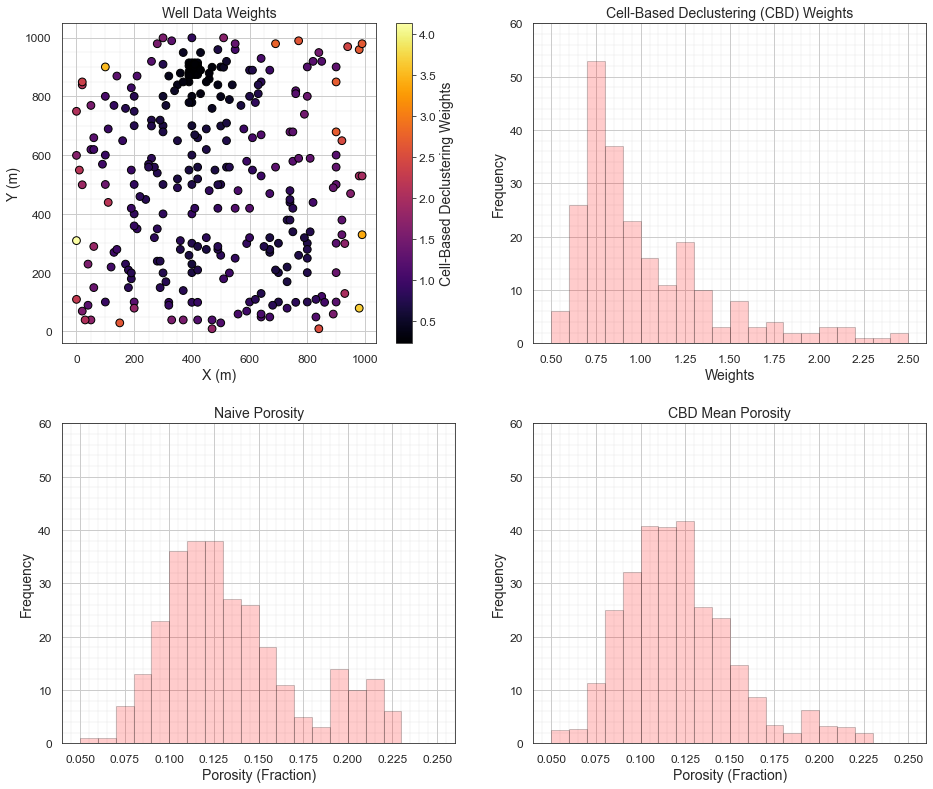

In [10]:
plt.subplot(221)
sc = plt.scatter(biased_samples['X'], biased_samples['Y'], c=biased_samples['Wts'], cmap=cmap, s=60, edgecolor='k')
plt.xlabel('X (m)', fontsize=14)
plt.ylabel('Y (m)', fontsize=14)
plt.title('Well Data Weights', fontsize=14)
plt.tick_params(axis='both', labelsize=12)

cbar = plt.colorbar(sc)
cbar.set_label('Cell-Based Declustering Weights', fontsize=14)
cbar.ax.tick_params(labelsize=12)
add_grid()

plt.subplot(222)
GSLIB.hist_st(biased_samples['Wts'],0.5,2.5,log=False,cumul=False,bins=20,weights=None, xlabel="Weights",title="Declustering Weights")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Weights", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Cell-Based Declustering (CBD) Weights", fontsize=14)
plt.ylim(0.0,60)
add_grid()

plt.subplot(223)
GSLIB.hist_st(biased_samples['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Porosity (Fraction)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Naive Porosity", fontsize=14)
plt.ylim(0.0,60)
add_grid()

plt.subplot(224)
GSLIB.hist_st(biased_samples['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=biased_samples['Wts'],xlabel="Porosity",title="Declustered Porosity")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Porosity (Fraction)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("CBD Mean Porosity", fontsize=14)
plt.ylim(0.0,60)
add_grid()


print('Porosity naive mean is ' + str(round(naive_mean,3)))
print('Porosity declustered mean for CBD is ' + str(round(CBD_mean,3)))
print('Using the naive porosity yields an error of ' + str(round(rel_CBD_error,2)) +'%')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.25); plt.show()

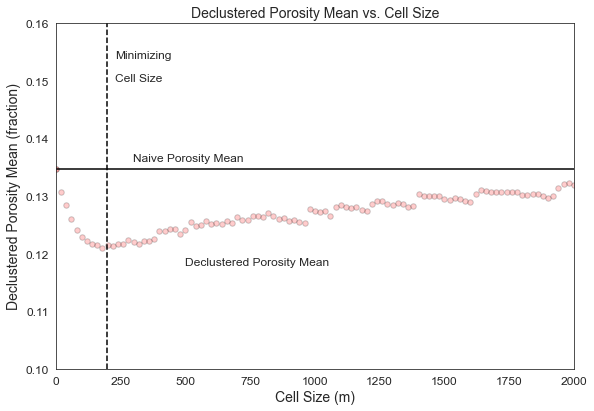

The minimizing CBD cell size is:  180.91 metres


In [11]:
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)', fontsize=14); plt.ylabel('Declustered Porosity Mean (fraction)', fontsize=14)
plt.title('Declustered Porosity Mean vs. Cell Size', fontsize=14)
plt.plot([0,2000],[naive_mean,naive_mean],color = 'black')
plt.plot([200,200],[0.10,0.16],color = 'black',linestyle='dashed')
plt.text(300., 0.136, r'Naive Porosity Mean', fontsize=12)
plt.text(500., 0.118, r'Declustered Porosity Mean', fontsize=12)
plt.text(230., 0.154, r'Minimizing', fontsize=12)
plt.text(230., 0.150, r'Cell Size', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.ylim(0.10,0.16); plt.xlim(0,2000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

print("The minimizing CBD cell size is: ", round(opt_cell,2), "metres")

# Spatial Statistics-based Assignment of Declustering Cell Size (SSADC)


The optimal cell size can be mathematically inferred as the distance that decouples the clustered dataset i.e. the distance at which clustering just starts to occur. Hence, we can answer the research prompt and verify the hypothesis stated earlier by using spatial statistics to evaluate inter-samples distance at which clustering occurs, and create a novel objective workflow.


 The point pattern is assumed to be “stationary” (statistically homogeneous) so that the Average Nearest Neighbors and Ripley’s K functions, be well defined and its corresponding estimators are approximately unbiased.


Next, we extract coordinates from prior analysis for each realization to enable it to be used.

In [12]:
temp = []
coord_list = []
XYcoords = x_and_y_vals
for key, value in XYcoords.items():
    temp = [key,value]
    coord_list.append(temp)
    
X_list = coord_list[0::2] # putting all the X coordinates for each realization into a list
Y_list = coord_list[1::2] # putting all the Y coordinates for each realization into a list

mylist = []
masterlist = []   
for i in range(0,len(data)):
    mylist = []
    xi = X_list[i][1]
    yi = Y_list[i][1]
    mylist.append(xi)
    mylist.append(yi)
    masterlist.append(mylist) #masterlist consists of arrays of X,Y in each realization

## Nearest Neighbors (NN)


The nearest-neighbor distance for an event in a point pattern is the distance from that event to the nearest event also in the point pattern. The distance between events at different locations may be calculated using the mean nearest-neighbor distance originally:


\begin{equation*}
\overline{r}_{min} = \frac{{\sum_{i=1}^{N} {\overline{r}_{min}(s_i)}}}{N}
\end{equation*} 
    

NN analysis measures the average distance from each point in the study area to its nearest point. An extension of this idea was used for in this work to plot the NN values for different order neighbors, i.e., for the first closest point, then the second-closest point, and so forth. Also, the shape of the NN curve as a function of ordered neighbors can provide insight into the spatial arrangement of points relative to one another. (Clarks and Evans, 1954)


Based on the nature of the problem, we can automate the elbow identification and keep track of the distance at which it occurs, then replace the optimal cell size from the current approach by adapting the method used in a similar problem of DBSCAN clustering when estimating the neighborhood radius of a search window from a k-distance or nearest neighbor plot.

In [13]:
# Automation of elbow location for each realization and storage to a list named elbows for NN

elbows = []

for j in range(0,len(data)):
    
# conversion of the masterlist to ndarray then dataframes for nearest neighbour    
    array_2d = np.array(masterlist[j])
    df_coord = pd.DataFrame(data = array_2d)
    df_coord.rename(index = {0:'X', 1:'Y'}, inplace=True)
    df_coord = df_coord.transpose()
    
# Using Nearest Neighbor analysis to find the distance between the samples
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df_coord[['X','Y']].values)
    distances, indices = nbrs.kneighbors(df_coord[['X','Y']].values)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    
    # Optimal Eps in each elbow identification for every realization
    data_2 = pd.DataFrame(data = distances)     
    data_2['indices'] = [i for i in range(0,len(data_2))]
    data_2.rename(columns = {0:'distances'}, inplace=True)
    knee_pt = KneeLocator(data_2['indices'],data_2['distances'], S=1.0, curve='convex', direction='increasing')
    elbow_val = data_2.loc[data_2['indices'] == knee_pt.knee,'distances'].iloc[0] 
    elbows.append(elbow_val)
    
# Save intersample distances at each elbows for all realizations into file
np.save('elbows', elbows)

If loading stored cell sizes at NN elbow points from file run the next cell 

In [14]:
# elbows = np.load('elbows.npy')

Visualize the elbow location from the K-distance/nearest neighbor plot to determine the cell size to use.

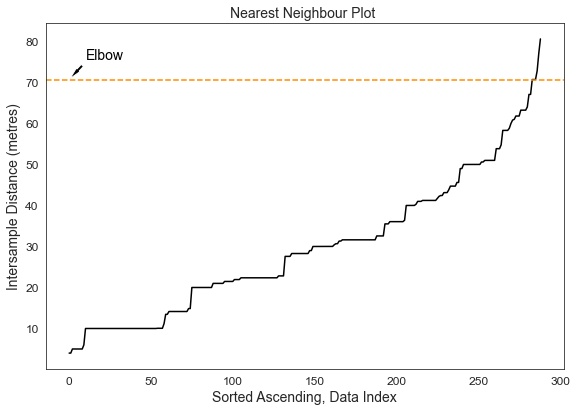

The intersample distance at the elbow (i.e., nearest neighbor cell size) is:  70.71 metres


In [15]:
plt.plot(distances, c='black')
plt.xlabel('Sorted Ascending, Data Index', fontsize=14)
plt.ylabel('Intersample Distance (metres)', fontsize=14)
plt.title('Nearest Neighbour Plot ', fontsize=14)
plt.tick_params(axis='both', labelsize=12)

# Draw a dashed horizontal line at the elbow point
plt.axhline(y=elbows[0], color='darkorange', linestyle='--')

# Annotate the elbow point on the plot
plt.annotate('Elbow', xy=(0, elbows[0]), xytext=(10, elbows[0]+5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=3, headwidth=5),
             fontsize=14, color='k')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

print('The intersample distance at the elbow (i.e., nearest neighbor cell size) is: ', round(elbows[0],2), 'metres')

Now, let's run cell-based declustering again using the cell size from nearest neighbors.

In [16]:
df_biasedNN = biased_samples.copy()

wts, cell_sizes, dmeans = declus(df_biasedNN,'X','Y',name,iminmax = 1, noff= 10, ncell=1,cmin=int(elbows[0]),cmax=int(elbows[0]))
df_biasedNN['Wts'] = wts

naive_mean = np.average(df_biasedNN[name].values)
NN_mean = np.average(df_biasedNN[name].values, weights=df_biasedNN['Wts'].values)
rel_NN_error = ((naive_mean-NN_mean)*100)/naive_mean
opt_cell = cell_sizes[np.where(np.isin(dmeans, dmeans.min()))].item(0)

NN_result = {
    'NNpor': [NN_mean],
    'rel_NN': [rel_NN_error],
    'NN_cellsize': [opt_cell]
}

# Extend the existing result dictionary with the new data
result.update(NN_result)

#Let's convert the result dictionary created to dataframe consisting of needed variables.
data = pd.DataFrame.from_dict(result)
# data.to_csv( "Updated_NN_Example_result.csv")

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385208 


Porosity naive mean is 0.135
Porosity declustered mean from SSADC - Nearest Neighbor is 0.125
Using the naive porosity yields an error of 7.07%


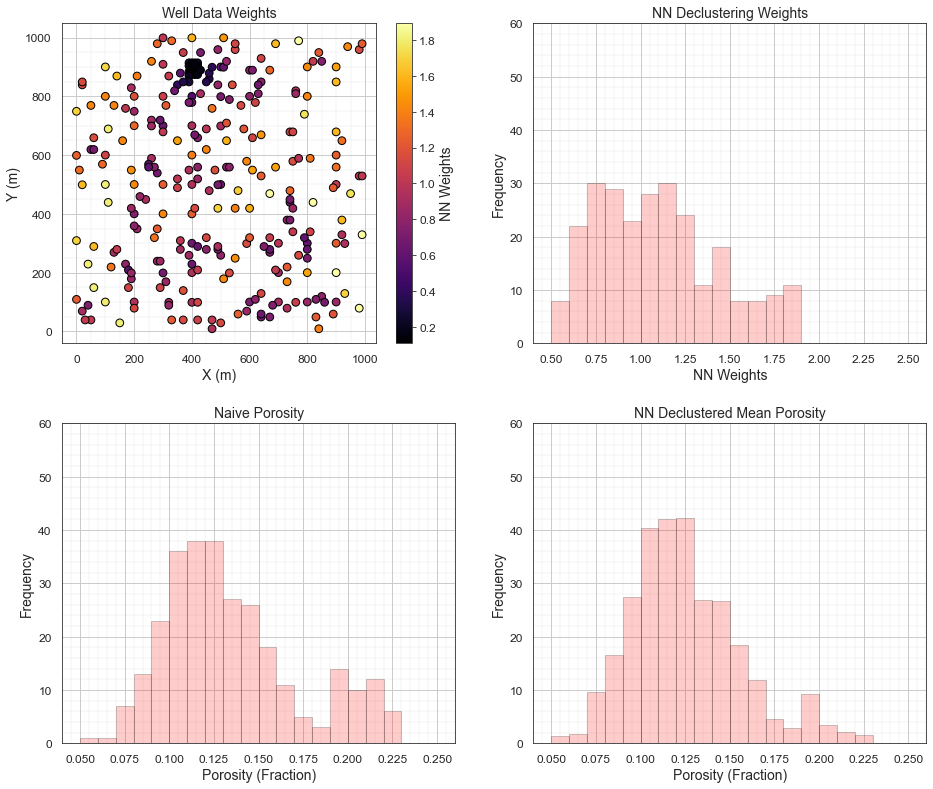

In [17]:
plt.subplot(221)
sc = plt.scatter(df_biasedNN['X'], df_biasedNN['Y'], c=df_biasedNN['Wts'], cmap=cmap, s=60, edgecolor='k')
plt.xlabel('X (m)', fontsize=14)
plt.ylabel('Y (m)', fontsize=14)
plt.title('Well Data Weights', fontsize=14)
plt.tick_params(axis='both', labelsize=12)

cbar = plt.colorbar(sc)
cbar.set_label('NN Weights', fontsize=14)
cbar.ax.tick_params(labelsize=12)
add_grid()

plt.subplot(222)
GSLIB.hist_st(df_biasedNN['Wts'],0.5,2.5,log=False,cumul=False,bins=20,weights=None, xlabel="Weights",title="NN Declustering Weights")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("NN Weights", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("NN Declustering Weights", fontsize=14)
plt.ylim(0.0,60)
add_grid()

plt.subplot(223)
GSLIB.hist_st(df_biasedNN['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Porosity (Fraction)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Naive Porosity", fontsize=14)
plt.ylim(0.0,60)
add_grid()

plt.subplot(224)
GSLIB.hist_st(df_biasedNN['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df_biasedNN['Wts'],xlabel="Porosity",title="NN Declustered Porosity")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Porosity (Fraction)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("NN Declustered Mean Porosity", fontsize=14)
plt.ylim(0.0,60)
add_grid()

print('Porosity naive mean is ' + str(round(naive_mean,3)))
print('Porosity declustered mean from SSADC - Nearest Neighbor is ' + str(round(NN_mean,3)))
print('Using the naive porosity yields an error of ' + str(round(rel_NN_error,2)) +'%')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.25); plt.show()

## Ripley's K


The second method in the SSADC approach is the Ripley’s K-function, which measures the randomness of a point pattern over a given spatial domain at a specified scale r. The K-function compares the expected number of points within a local neighborhood of radius r at any point in the dataset versus the expected density assuming complete spatial randomness (CSR). Here, we will assume a 2D point process. (Ripley, 1976)


\begin{equation*}
K(r) = \frac{{\sum_{i=1}^N \sum_{j=1 , j\neq i}^N  {{I_j}(d)_{ij}} }}{\lambda N}
\end{equation*}


Let's load the csv file generated in Rstudio consisting of the cell size at the maximum curvature departure from complete spatial random.

In [18]:
df_ripley = pd.read_csv("cellsizes_Ripley_example.csv", index_col=0) # Load results from R software
df_K = df_ripley.reset_index(drop=True)

Convert each column in the dataframe to individual lists for ease

In [19]:
max_curvs = df_K["max_curv"].tolist()

Now, let's run cell-based declustering again using the cell size from Ripley's K.

In [20]:
df_biasedK = biased_samples.copy()

wts, cell_sizes, dmeans = declus(df_biasedK,'X','Y',name,iminmax = 1, noff= 10, ncell=1,cmin=int(max_curvs[0]),cmax=int(max_curvs[0]))
df_biasedK['Wts'] = wts

naive_mean = np.average(df_biasedK[name].values)
K_mean = np.average(df_biasedK[name].values, weights=df_biasedK['Wts'].values)
rel_K_error = ((naive_mean-K_mean)*100)/naive_mean # correction made
opt_cell = cell_sizes[np.where(np.isin(dmeans, dmeans.min()))].item(0)

K_result = {
    'Kpor': [K_mean],
    'rel_K': [rel_K_error],
    'K_cellsize': [opt_cell]
}

# Extend the existing result dictionary with the new data
result.update(K_result)

#Let's convert the result dictionary created to dataframe consisting of needed variables.
data = pd.DataFrame.from_dict(result)
data.to_csv( "Example_results.csv")
# data.head()

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385208 


Porosity naive mean is 0.135
Porosity declustered mean from SSADC - Ripley's K is 0.122
Using the naive porosity yields an error of 9.09%


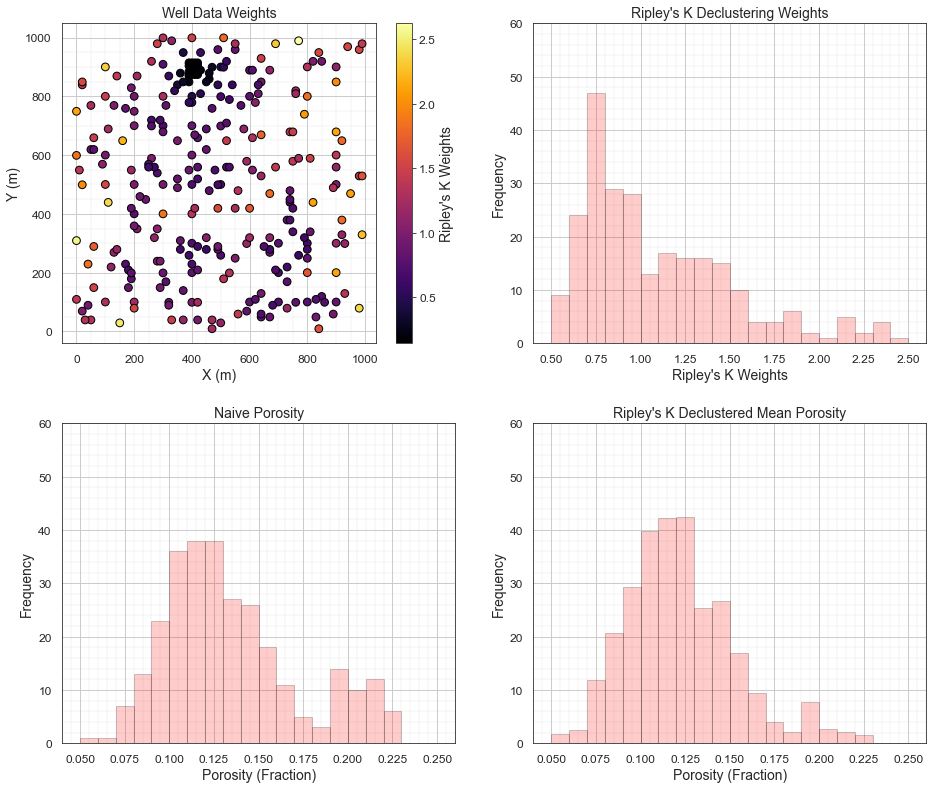

In [21]:
plt.subplot(221)
sc = plt.scatter(df_biasedK['X'], df_biasedK['Y'], c=df_biasedK['Wts'], cmap=cmap, s=60, edgecolor='k')
plt.xlabel('X (m)', fontsize=14)
plt.ylabel('Y (m)', fontsize=14)
plt.title('Well Data Weights', fontsize=14)
plt.tick_params(axis='both', labelsize=12)

cbar = plt.colorbar(sc)
cbar.set_label("Ripley's K Weights", fontsize=14)
cbar.ax.tick_params(labelsize=12)
add_grid()


plt.subplot(222)
GSLIB.hist_st(df_biasedK['Wts'],0.5,2.5,log=False,cumul=False,bins=20,weights=None, xlabel="Weights",title="Ripley's K Declustering Weights")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Ripley's K Weights", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Ripley's K Declustering Weights", fontsize=14)
plt.ylim(0.0,60)
add_grid()

plt.subplot(223)
GSLIB.hist_st(df_biasedK['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Porosity (Fraction)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Naive Porosity", fontsize=14)
plt.ylim(0.0,60)
add_grid()

plt.subplot(224)
GSLIB.hist_st(df_biasedK['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df_biasedK['Wts'],xlabel="Porosity",title="Ripley's K Declustered Porosity")
plt.tick_params(axis='both', labelsize=12)
plt.xlabel("Porosity (Fraction)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Ripley's K Declustered Mean Porosity", fontsize=14)
plt.ylim(0.0,60)
add_grid()

print('Porosity naive mean is ' + str(round(naive_mean,3)))
print("Porosity declustered mean from SSADC - Ripley's K is " + str(round(K_mean,3)))
print('Using the naive porosity yields an error of ' + str(round(rel_K_error,2)) +'%')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.25); plt.show()

Let's view the error or correction from each method of cellsize determination for cell based declustering.

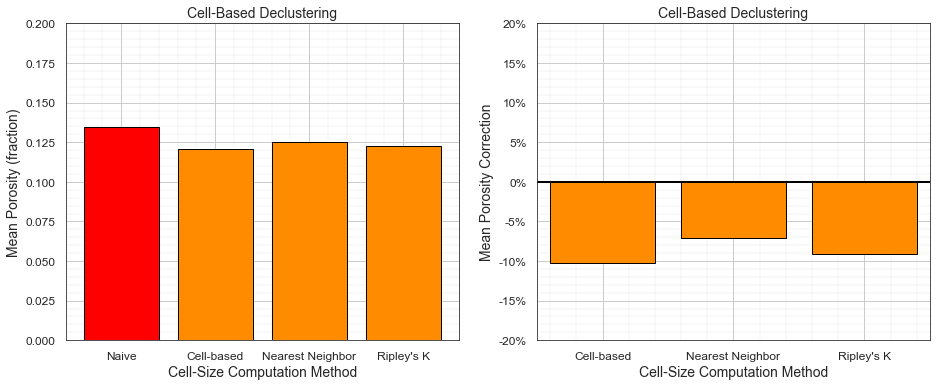

In [22]:
plt.subplot(121)
bar = plt.bar(['Naive','Cell-based','Nearest Neighbor',"Ripley's K"],[naive_mean,CBD_mean,NN_mean,K_mean],color='darkorange',edgecolor='black')
bar[0].set_color('red'); bar[0].set_edgecolor('black')
plt.ylim([0,0.20])
plt.title('Cell-Based Declustering', fontsize=14)
plt.ylabel('Mean Porosity (fraction)', fontsize=14)
plt.xlabel('Cell-Size Computation Method', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
add_grid()

plt.subplot(122)
plt.bar(['Cell-based','Nearest Neighbor',"Ripley's K"],[-rel_CBD_error, -rel_NN_error, -rel_K_error],color='darkorange',edgecolor='black')
plt.plot([-0.5,2.5],[0,0],color='black',lw=2); plt.xlim([-0.5,2.5])
plt.ylim([-20,20])
plt.title('Cell-Based Declustering', fontsize=14)
plt.ylabel('Mean Porosity Correction', fontsize=14)
plt.xlabel('Cell-Size Computation Method', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
fmt = '%.0f%%'
xticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(xticks)
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()